In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn.metrics import accuracy_score
import graphviz

In [32]:
file_path = "../drug200.csv"
data = pd.read_csv(file_path)

data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [33]:
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop('Drug')
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)


In [34]:
le = LabelEncoder()
data_encoded['Drug'] = le.fit_transform(data['Drug'])

In [35]:
X = data_encoded.drop('Drug', axis=1)
y = data_encoded['Drug']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
data_encoded.columns

Index(['Age', 'Na_to_K', 'Drug', 'Sex_M', 'BP_LOW', 'BP_NORMAL',
       'Cholesterol_NORMAL'],
      dtype='object')

# Arbol de decision
Normalmente para un random forest se usan arboles de decision binarios comunes, que se construyen usando CART, en donde dividen recursivamente los subconjuntos basados en una caracteristica que minimiza las impurezas, en este caso se uso la impureza de Gini

## Impureza de Gini (Funcion best_split)
Mide la frecuencia con la que un elemento elegido de forma aleatoria seria categorizado de forma incorrecta si se etiqueara aleatoriamente segun la distribucion de etiquetas del subconjunto.

## Muestreo aleatorio de caracteristicas
En cada nodo se seleccina un subconjunto aleatorio de caracteristicas para considerar la division, introduciendo variabilidad y reduciendo la correlacion entre los arboles mejorando la generalizacion del modelo

## Crecimiento completo (grow_tree)
Los arboles crecen hasata su maxima profundidad posible, es decir hasta que todas las hojas tienen menos de una cierta cantidad de instancias

In [38]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if n_samples == 0 or depth == self.max_depth:
            most_common_label = np.bincount(y).argmax()
            return most_common_label
        best_feat, best_thresh = self._best_split(X, y, n_features)
        if best_feat is None:
            most_common_label = np.bincount(y).argmax()
            return most_common_label
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return (best_feat, best_thresh, left, right)

    def _best_split(self, X, y, n_features):
        m, n = X.shape
        if m <= 1:
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes)]
        best_gini = 1.0 - sum((num / m) ** 2 for num in num_parent)
        best_feat, best_thresh = None, None
        for feat in range(n_features):
            thresholds, classes = zip(*sorted(zip(X[:, feat], y)))
            num_left = [0] * self.n_classes
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(self.n_classes))
                gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(self.n_classes))
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_feat = feat
                    best_thresh = (thresholds[i] + thresholds[i - 1]) / 2
        return best_feat, best_thresh

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _predict(self, inputs):
        node = self.tree
        while isinstance(node, tuple):
            if inputs[node[0]] <= node[1]:
                node = node[2]
            else:
                node = node[3]
        return node

# Funcionamiento del random forest:
El random forest se basa en la idea de ensamblar multiples arboles de decision, la idea siendo que se pueden combinar las predicciones de arios arboles para mejorar la precision y asi controlar el sobre ajuste

## Bootsrap sampling (Funcion fit)
Generacion de varios subconjuntos de datos a partir del original usando muestreo con reemplazo

## Construccion de arboles (En la clase del arbol la funcion grow_tree)
Para cada subconjunto se contruye un arbol de decision, en donde durante su construccion en cada nodo se selecciona un subconjunto aleatorio de caracteristicas en lugar de considerar todas las posibles

## Prediccion
Cuando ya se contruyen todos los arboles, el modelo hace predicciones basadas en el conjunto de arboles, para cada tarea el arbol elige una clase y la clase que mas fue elegida es la que se usa para el modelo, siendo la predicion final el promedio de las predicciones de todos los arboles

In [39]:
class RandomForest:
    def __init__(self, n_trees=100, max_depth=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            idxs = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return mode(tree_preds, axis=0)[0].flatten()


In [40]:
def get_patient_data():
    # Ingresar las características del paciente
    age = int(input("Ingrese la edad del paciente: "))
    sex = input("Ingrese el sexo del paciente (F/M): ")
    bp = input("Ingrese la presión sanguínea del paciente (HIGH/LOW/NORMAL): ")
    cholesterol = input("Ingrese el nivel de colesterol del paciente (HIGH/NORMAL): ")
    na_to_k = float(input("Ingrese la relación Na_to_K del paciente: "))

    # Crear un DataFrame con los datos ingresados
    patient_data = pd.DataFrame({
        'Age': [age],
        'Sex': [sex],
        'BP': [bp],
        'Cholesterol': [cholesterol],
        'Na_to_K': [na_to_k]
    })

    # Aplicar las mismas transformaciones que en los datos de entrenamiento
    categorical_columns = patient_data.select_dtypes(include=['object']).columns
    patient_data_encoded = pd.get_dummies(patient_data, columns=categorical_columns, drop_first=True)

    # Asegurarse de que las columnas del DataFrame del paciente coincidan con las del conjunto de entrenamiento
    missing_cols = set(X_train.columns) - set(patient_data_encoded.columns)
    for col in missing_cols:
        patient_data_encoded[col] = 0
    patient_data_encoded = patient_data_encoded[X_train.columns]

    return patient_data_encoded.values

In [41]:
rf = RandomForest(n_trees=10, max_depth=5)
rf.fit(X_train.values, y_train.values)

# Realizar predicciones
y_pred = rf.predict(X_test.values)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 1.00


In [42]:
patient_data = get_patient_data()

# Predecir el mejor medicamento para el paciente
predicted_drug = rf.predict(patient_data)
predicted_drug_label = le.inverse_transform(predicted_drug)[0]

print(f'El mejor medicamento para el paciente es: {predicted_drug_label}')

El mejor medicamento para el paciente es: drugA


In [43]:
def visualize_tree(tree, feature_names, parent_name='', graph=None):
    if graph is None:
        graph = graphviz.Digraph()
        graph.node(name='root', label='Root')

    if isinstance(tree, tuple):
        feature, threshold, left, right = tree
        node_name = f'{feature}_{threshold}'
        graph.node(name=node_name, label=f'{feature_names[feature]} <= {threshold:.2f}')
        if parent_name:
            graph.edge(parent_name, node_name)
        else:
            graph.edge('root', node_name)
        visualize_tree(left, feature_names, node_name, graph)
        visualize_tree(right, feature_names, node_name, graph)
    else:
        leaf_name = f'leaf_{tree}'
        graph.node(name=leaf_name, label=str(tree))
        graph.edge(parent_name, leaf_name)
    
    return graph

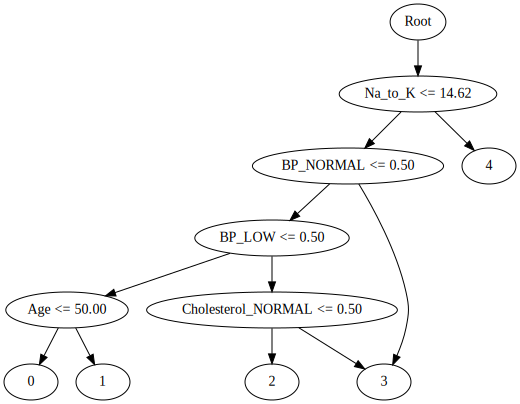

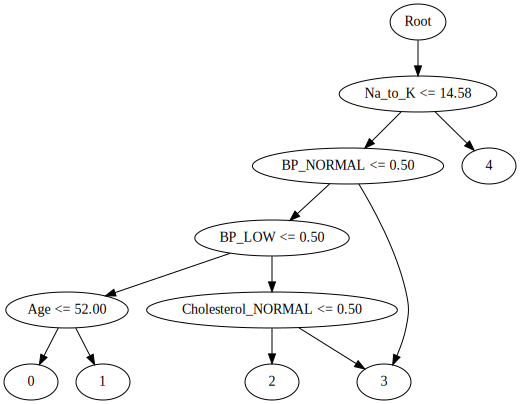

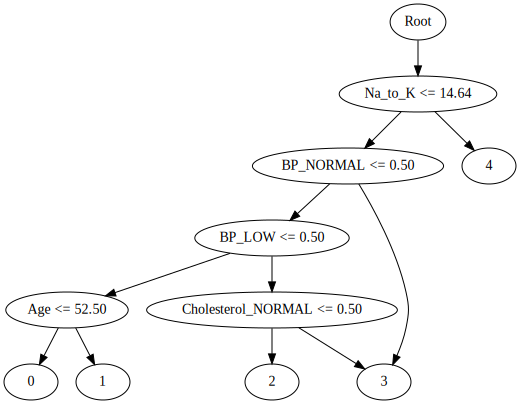

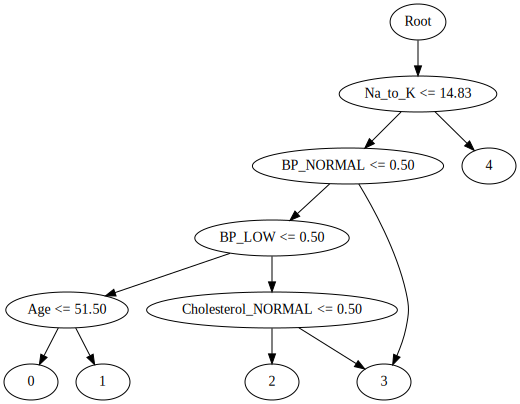

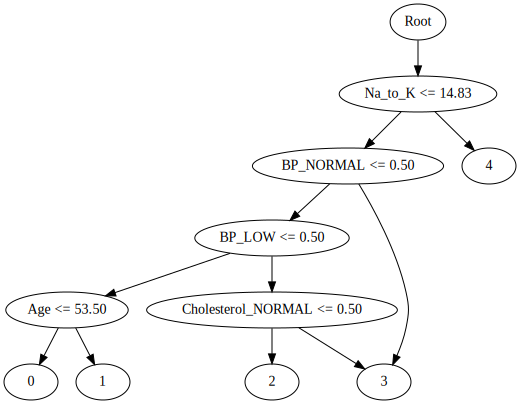

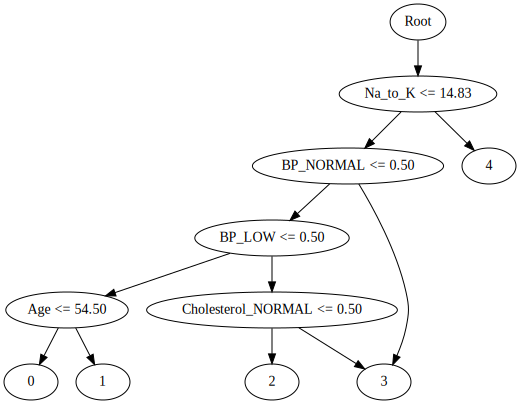

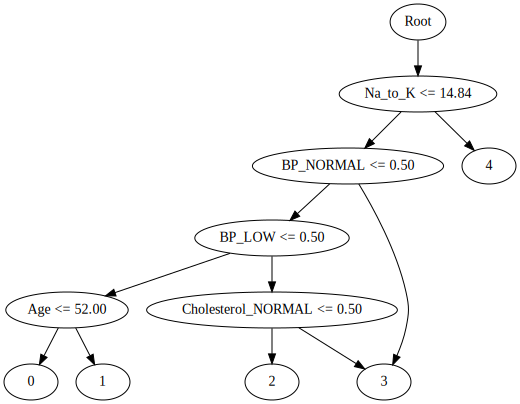

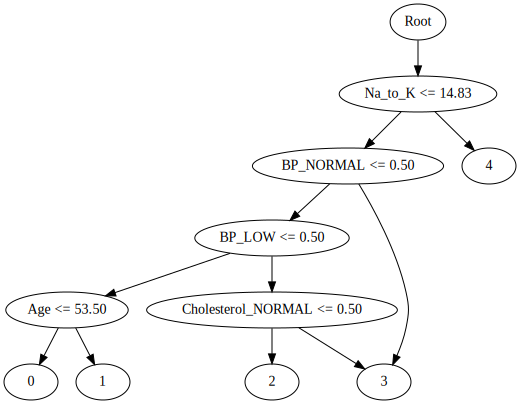

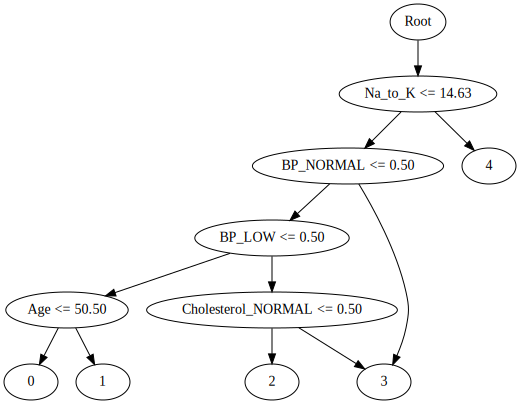

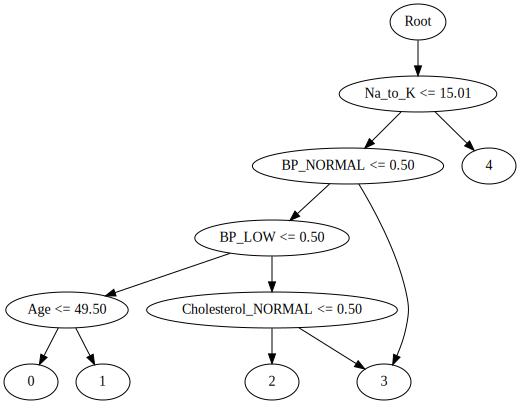

In [44]:
for i, tree in enumerate(rf.trees):
    graph = visualize_tree(tree.tree, X_train.columns)
    graph.render(f'rf_tree_{i}')
    display(graph)

In [45]:
le.classes_

array(['drugA', 'drugB', 'drugC', 'drugX', 'drugY'], dtype=object)

In [46]:
def calculate_depth(tree):
    if not isinstance(tree, tuple):
        return 0
    else:
        _, _, left, right = tree
        return 1 + max(calculate_depth(left), calculate_depth(right))
    
depths = [calculate_depth(tree.tree) for tree in rf.trees]
for i, depth in enumerate(depths):
    print(f'Profundidad del árbol {i}: {depth}')

# Mostrar el número de árboles
print(f'Número de árboles en el Random Forest: {rf.n_trees}')

Profundidad del árbol 0: 4
Profundidad del árbol 1: 4
Profundidad del árbol 2: 4
Profundidad del árbol 3: 4
Profundidad del árbol 4: 4
Profundidad del árbol 5: 4
Profundidad del árbol 6: 4
Profundidad del árbol 7: 4
Profundidad del árbol 8: 4
Profundidad del árbol 9: 4
Número de árboles en el Random Forest: 10
